# Visualizing batch effects between HBN and HNU1 datasets
Vivek Gopalakrishnan | February 16, 2019

### Overview:
Batch effects are the manifestation of technical variation introduced by the data collection process. In this notebook, I visually demonstrate the existence of batch effects in connectome data by embedding a subset of the HBN and HNU1 datasets in the same Euclidean space.

### Procedure:
`cMDS o OMNI o PTR`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx
import graspy as gs
from graspy.utils import import_graph

from collections import OrderedDict
import os

### Import data
- Load graphs, pass-to-ranks, and save to specific array. 
- Filter out graphs that do not have 70 nodes (these are errors).
- Note that different nx functions are required to HBN and HNU1 data.

In [2]:
hbn = []
hnu = []
swu = []

# Load HBN
for root, dirs, files in os.walk('../../data/HBN'):
    
    for graph in files:
        if graph.endswith(".edgelist"):
            graph_path = os.path.join(root, graph)
            G = nx.read_weighted_edgelist(graph_path)
            G = gs.utils.pass_to_ranks(G)
            if G.shape == (70, 70):
                hbn.append(G)
            
# Load HNU1
for root, dirs, files in os.walk('../../data/HNU1'):
    
    for graph in files:
        if graph.endswith(".edgelist"):
            graph_path = os.path.join(root, graph)
            G = nx.read_edgelist(graph_path)
            G = gs.utils.pass_to_ranks(G)
            if G.shape == (70, 70):
                hnu.append(G)

# Load SWU4
for root, dirs, files in os.walk('../../data/SWU4'):
    
    for graph in files:
        if graph.endswith(".edgelist"):
            graph_path = os.path.join(root, graph)
            G = nx.read_edgelist(graph_path)
            G = gs.utils.pass_to_ranks(G)
            if G.shape == (70, 70):
                swu.append(G)
                
# Convert to numpy array
hbn = np.array(hbn)
hnu = np.array(hnu)
swu = np.array(swu)
print("Number of patients in HBN: {}".format(len(hbn)))
print("Number of patients in HNU1: {}".format(len(hnu)))
print("Number of patients in SWU4: {}".format(len(swu)))

Number of patients in HBN: 99
Number of patients in HNU1: 300
Number of patients in SWU4: 453


Run the lines below if you want the phenotypic data for the HNU1 data.

In [3]:
# df = pd.read_csv('../../data/HNU1/subject_data.csv')
# age = df['age'].values.reshape(-1, 1)
# sex = df['sex'].values.reshape(-1, 1)

### Embed a subset of the two datasets using Omni

I have chosen to embed 75 brains from each dataset.

In [4]:
def embed(data, n_components=50, n_population=75):
    """Embed a subset of an array of connectomes (data) in specified number of dimensions."""
    
    omni = gs.embed.OmnibusEmbed(n_components=n_components)
    Zhat = omni.fit_transform(
        data[np.random.choice(len(data), size=n_population)]
    )
    
    return Zhat

In [5]:
# Constants
n_components = 50
n_population = 50

# Embed the data
Zhat_hbn = embed(hbn, n_population=n_population)
Zhat_hnu = embed(hnu, n_population=n_population)
Zhat_swu = embed(swu, n_population=n_population)

# Verify embedding shapes for sanity
print(Zhat_hbn.shape)
print(Zhat_hnu.shape)
print(Zhat_swu.shape)

(3500, 50)
(3500, 50)
(3500, 50)


In [6]:
# Combine embeddings
Zhat = np.vstack([Zhat_hbn, Zhat_hnu, Zhat_swu])
print(Zhat.shape)

# Tensor: subject x node x Euclidean representation
Zhat = Zhat.reshape((n_population * 3, 70, -1))
print(Zhat.shape)

(10500, 50)
(150, 70, 50)


### Reduce the dimension of Omni embedding using CMDS

In [7]:
# Dim reduce: subject x components
cmds = gs.embed.ClassicalMDS(n_components=20)
Xhat = cmds.fit_transform(Zhat)
print(Xhat.shape)

(150, 20)


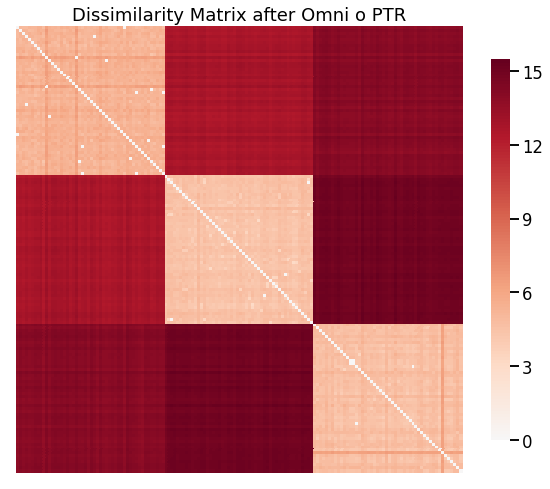

In [8]:
# Visualize dissimilarity matrix
# Diagonal is comparing scan to itself
# (n,n) blocks on the diagonal are comparing scans from the same subject
gs.plot.heatmap(cmds.dissimilarity_matrix_, title='Dissimilarity Matrix after Omni o PTR')
plt.show()

### Visualize the first 5 dimensions using a pairs plot

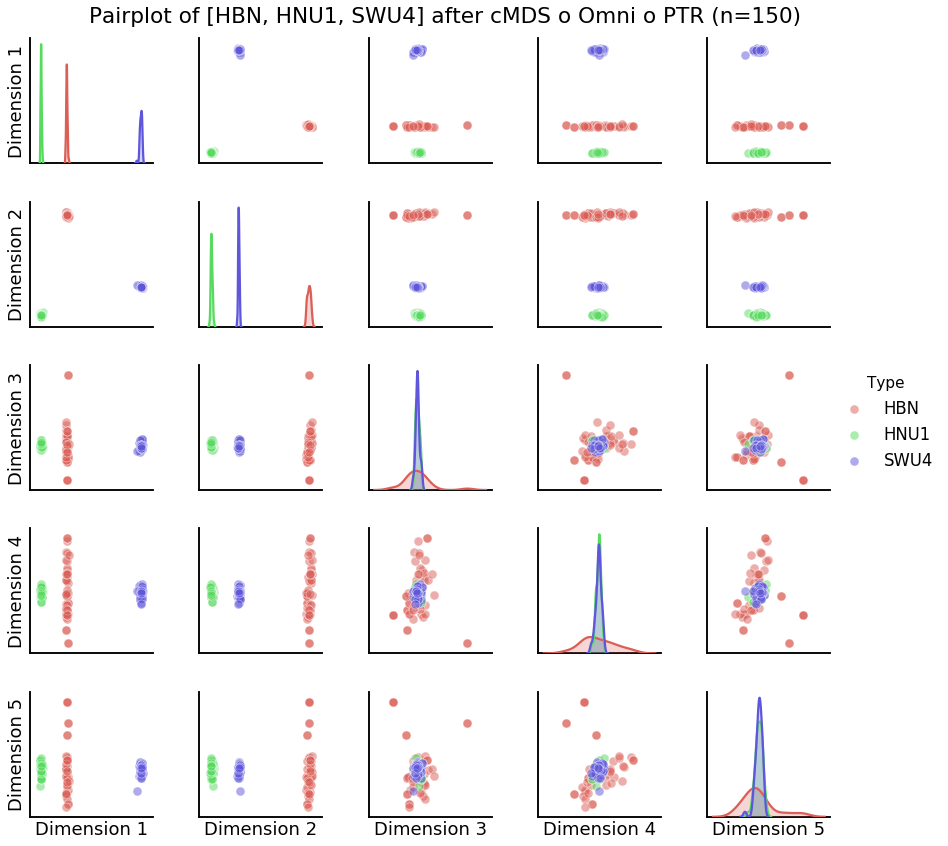

In [9]:
# Labels for dimensions
variables = ['Dimension {}'.format(i) for i in range(1, Xhat.shape[1] + 1)]
labels = ['HBN']*n_population + ['HNU1']*n_population + ['SWU4']*n_population

# Pair plot of first 5 components of CMDS
gs.plot.pairplot(Xhat, 
                 alpha=0.5,
                 Y=labels, 
                 palette='hls', 
                 col_names=variables, 
                 variables=variables[:5], 
                 title='Pairplot of [HBN, HNU1, SWU4] after cMDS o Omni o PTR (n={})'.format(n_population*3))
plt.show()